In [35]:
import os
import sys

import numpy as np
import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from streamfunction_ecco import streamfunction_custom_utils as strf_utils

import matplotlib.pyplot as plt

In [2]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

#### A. COLLECT THE NEEDED DATA

1. Prepare the RAPID streamfunction in the correct format

In [3]:
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc"))

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

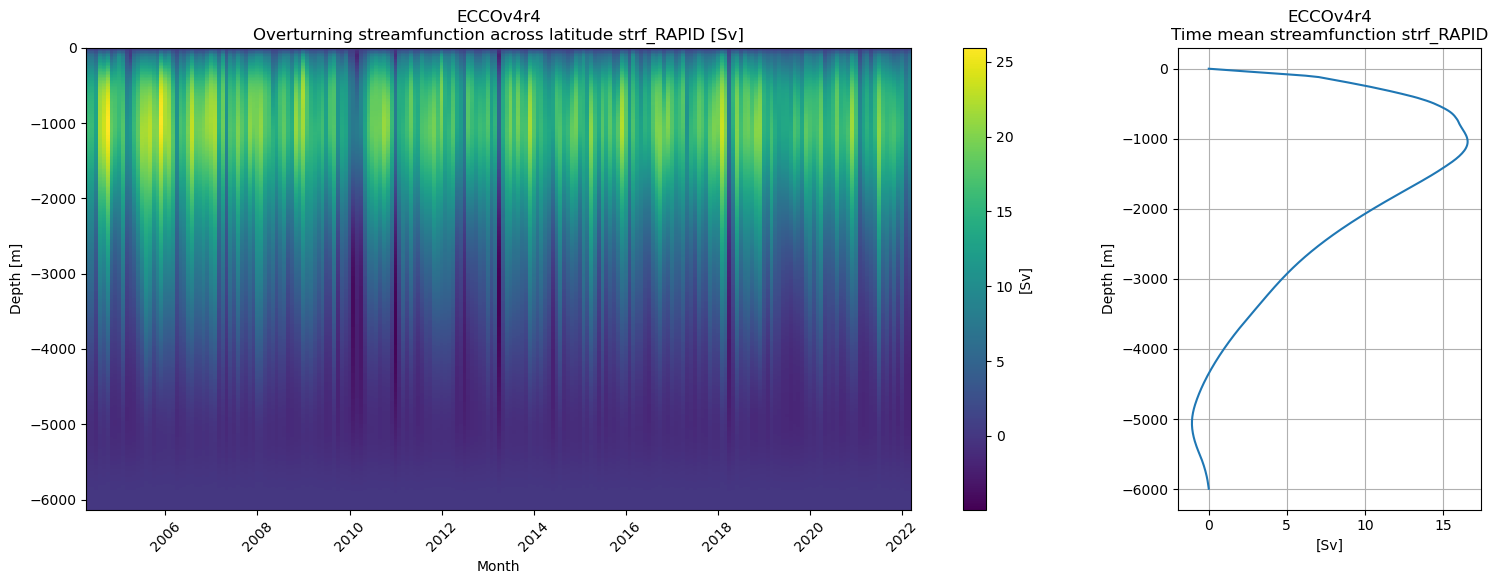

In [4]:
RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")

# Resample to monthly mean values
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = strf_utils.get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')

strf_utils.plot_depth_stf_vs_time(stf_ds=PSI_RAPID.squeeze(), label='strf_RAPID', param='psi_moc')

2. Get the Input Surface variables at 30S for the atlantic basin

In [5]:
lat = lats[1]
lat_str = strf_utils.format_lat_lon(lat)

lon_min = -50
lon_max = 17

inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat_str}.nc").isel(latitude=slice(1,2))
inputs = inputs.sel(longitude=slice(lon_min, lon_max))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 134)
Coordinates:
  * latitude   (latitude) float32 -29.75
  * longitude  (longitude) float32 -49.75 -49.25 -48.75 ... 15.75 16.25 16.75
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

3. Retrieve the 30S depth streamfunctions for the upper and lower cell

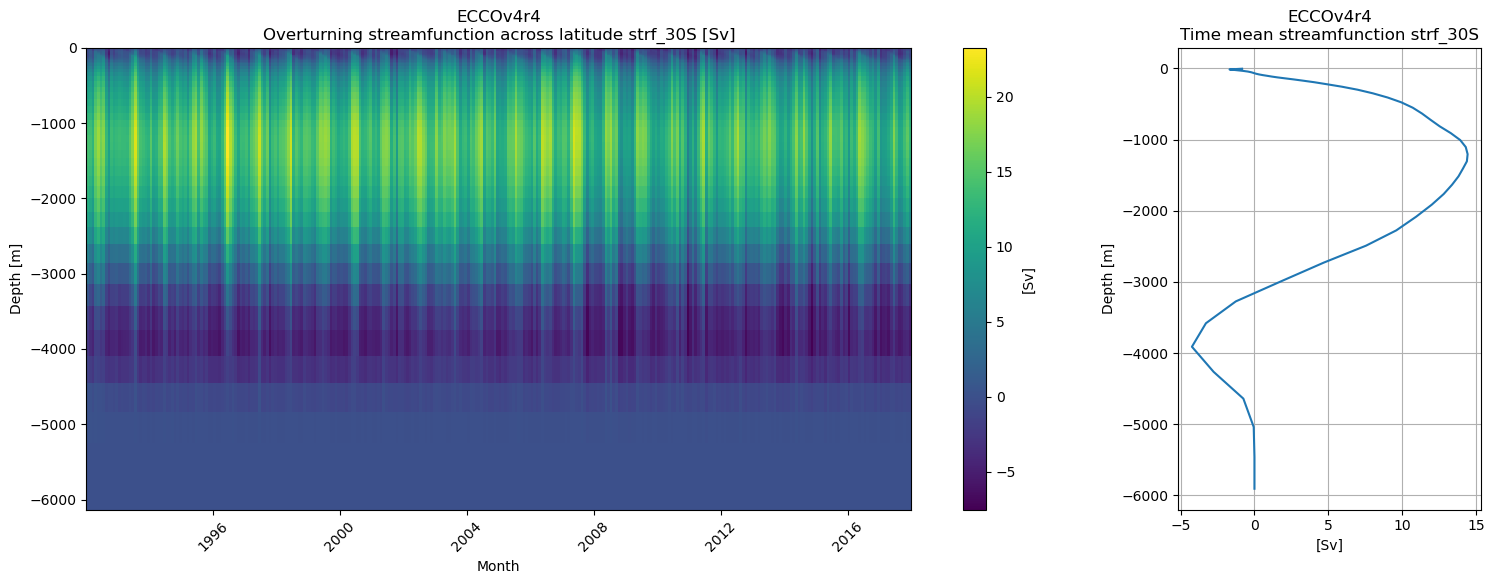

In [6]:
extra_str = 'atlantic_sf'
strf_fp = f"{data_home}/ecco_data_minimal/{lat_str}_{extra_str}_depth.pickle"
depth_fp = f"{data_home}/ecco_data_minimal/depth_range.pickle"
ECCO_GRID = xr.open_dataset(paths.geom_fp)

with open(strf_fp, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1] #Load the streamfunction and invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
strf = np.transpose(strf, (2,0,1))
    
strf = xr.Dataset(
        data_vars = {'moc' : (["time", "k", "latitude"], strf)}, 
        coords = {'time' : inputs.time,  'k': np.arange(50), 'latitude' : np.atleast_1d(-60)}
        )

strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

outputs_upper_cell = strf_utils.get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
outputs_bottom_cell = strf_utils.get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

strf_utils.plot_depth_stf_vs_time(stf_ds=strf.squeeze(), label='strf_30S', param='moc')

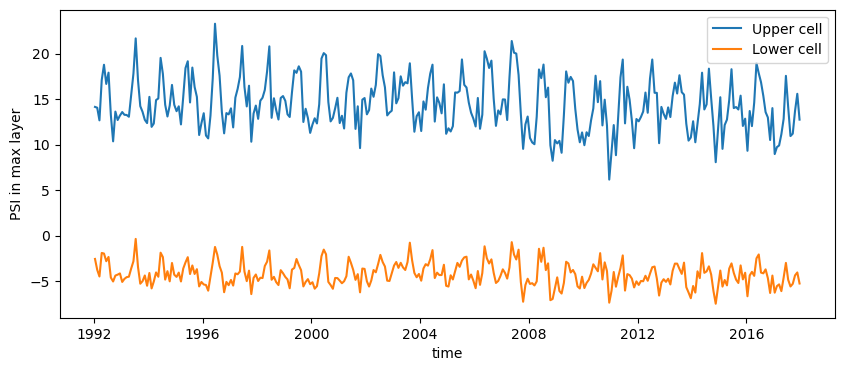

In [7]:
# Plot both streamfunctions for a sanity check

plt.figure(figsize = (10, 4))
plt.plot(outputs_upper_cell["time"].squeeze(), outputs_upper_cell["moc"].squeeze(), label='Upper cell')   
plt.plot(outputs_bottom_cell["time"].squeeze(), outputs_bottom_cell["moc"].squeeze(), label='Lower cell') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

#### B. Align the data inputs

In [8]:
# Decide which of the streamfunctions at 30S to predict
outputs = outputs_upper_cell

In [9]:
# RAPID has the latest start date and the ECCO data has the earliest end date (combine)
date_range = (RAPID_inputs.time.values[0], inputs.time.values[-1]) 
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)

# Align the surface variable inputs with RAPID, then align the in- and outputs
inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('2004-04-30', '2017-12-16')


In [197]:
# Apply standardization to both RAPID and surface data (can't be done together as the longitude dimension still differs in both)
pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=False,
                                    remove_trend=False,
                                    standardize=True,
                                    lowpass=False)

pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, history=6, keep_coords=["time"], data_vars=["psi_moc"])*3
pp_data_SURFACE_np = reshape_inputs(pp_data_surface, history=6, keep_coords=["time"], data_vars=["SST", "OBP", "ZWS"])

# Concatenate the different information layers together
pp_data_np = np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)
#pp_data_np = pp_data_SURFACE_np
X = pp_data_np

axes: ['time', 'history', 'feature']
variables: ['psi_moc']
shape: (159, 6, 1)
axes: ['time', 'history', 'feature']
variables: ['SST', 'OBP', 'ZWS']
shape: (159, 6, 3)


In [198]:
# MOC strength preprocessing
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
    
# Necessary step to do convolutions along the right axis with pytorch tensors!
dims = list(range(X.ndim))  
dims[1], dims[-1] = dims[-1], dims[1]
X = np.transpose(X, dims)

conv_dims = 1
if len(X.shape) == (conv_dims + 1):
    X = np.expand_dims(X, axis=-1)

y = strength_np[-X.shape[0]:]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)


Inputs shape: (159, 4, 6)
Outputs shape: (159,)


#### C. Define train (validation) and test sets and perform training

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device).double()
Yt_train = t.tensor(y_train, device=device).double()
Xt_valid = t.tensor(X_valid, device=device).double()
Yt_valid = t.tensor(y_valid, device=device).double()
Xt_test = t.tensor(X_test, device=device).double()
Yt_test = t.tensor(y_test, device=device).double()

device: cpu


In [200]:
import importlib
from models import train_alt, CNN1D, CNN2D

importlib.reload(train_alt)
importlib.reload(CNN1D)
importlib.reload(CNN2D)

<module 'models.CNN2D' from 'C:\\Users\\aline\\OTP\\models\\CNN2D.py'>

In [201]:
dropout = 0.2
n_pure_layers = 1
n_mix_layers = 2
n_features = 4
n_channels = n_features * 5
kernel_size = 3
model_iterations = 10

def train_CNN():

    model = CNN1D.CNN1D(
        n_pure_layers=n_pure_layers, 
        n_mix_layers=n_mix_layers, 
        n_features=n_features, 
        n_channels=n_channels,
        kernel_size=kernel_size,
        dropout=dropout
    ).double()

    model, train_loss, val_loss = train_alt.train_model(
        model=model, 
        X_train = Xt_train, 
        y_train = Yt_train, 
        X_val = Xt_valid,
        y_val = Yt_valid, 
        early_stopping=True,
        patience=2000,
    )
    return model

models = []
for i in range(model_iterations):
    models.append(train_CNN())

device: cpu
1721 parameters.


 64%|██████▎   | 3180/5000 [00:18<00:10, 171.24it/s]


early stopping at 3180 iterations
device: cpu
1721 parameters.


 76%|███████▌  | 3776/5000 [00:21<00:06, 178.09it/s]


early stopping at 3776 iterations
device: cpu
1721 parameters.


 97%|█████████▋| 4870/5000 [00:28<00:00, 170.27it/s]


early stopping at 4870 iterations
device: cpu
1721 parameters.


100%|██████████| 5000/5000 [00:29<00:00, 170.82it/s]


device: cpu
1721 parameters.


 65%|██████▌   | 3263/5000 [00:18<00:09, 173.93it/s]


early stopping at 3263 iterations
device: cpu
1721 parameters.


 65%|██████▍   | 3247/5000 [00:18<00:10, 171.40it/s]


early stopping at 3247 iterations
device: cpu
1721 parameters.


100%|██████████| 5000/5000 [00:29<00:00, 168.74it/s]


device: cpu
1721 parameters.


 85%|████████▌ | 4266/5000 [00:24<00:04, 172.10it/s]


early stopping at 4266 iterations
device: cpu
1721 parameters.


 88%|████████▊ | 4387/5000 [00:25<00:03, 173.25it/s]


early stopping at 4387 iterations
device: cpu
1721 parameters.


100%|██████████| 5000/5000 [00:38<00:00, 128.80it/s]


In [202]:
def predict_CNN(model):

    # Extracting all predictions in time order
    train_set_pred = train_alt.predict(model, Xt_train, Yt_train)
    valid_set_pred = train_alt.predict(model, Xt_valid, Yt_valid)
    test_set_pred = train_alt.predict(model, Xt_test, Yt_test)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    metrics = {
        "r2": round(r2_score(test_set_pred, y_test), 3),
        "mse": round(mean_squared_error(test_set_pred, y_test), 3),
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,
        #"cmape": round(custom_MAPE(test_set_pred, y_test), 3),
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        "train_corr": round(np.corrcoef(np.array(train_set_pred).squeeze(), y_train)[0, 1], 3)
        }
    
    return predictions, metrics

predictions_models = []
metrics_models = []

for i in range(len(models)):
    predictions, metrics = predict_CNN(models[i])
    predictions_models.append(predictions)
    metrics_models.append(metrics)

metrics_df = pd.DataFrame(metrics_models)
summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

predictions_df = pd.DataFrame(predictions_models)

,mean,std
r2,-0.889,1.323
mse,4.907,1.482
rmse,2.193,0.328
mae,1.796,0.260
mape,12.460,1.354
test_corr,0.709,0.074
train_corr,0.963,0.010


In [193]:
display(summary_metrics_df)

,mean,std
r2,-1.192,0.494
mse,6.802,0.929
rmse,2.603,0.179
mae,2.138,0.162
mape,14.570,1.278
test_corr,0.484,0.081
train_corr,0.950,0.012


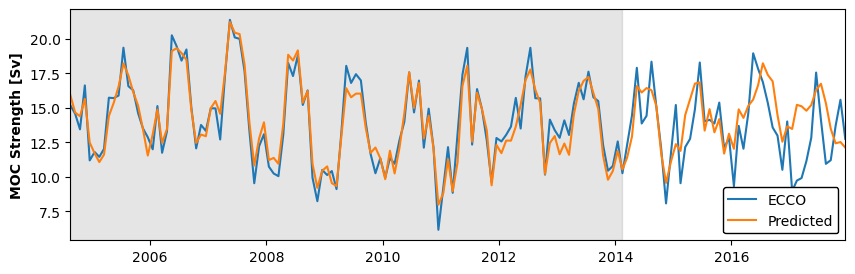

In [185]:
mean_arrays = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}
all_preds = mean_arrays['all_preds']
time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

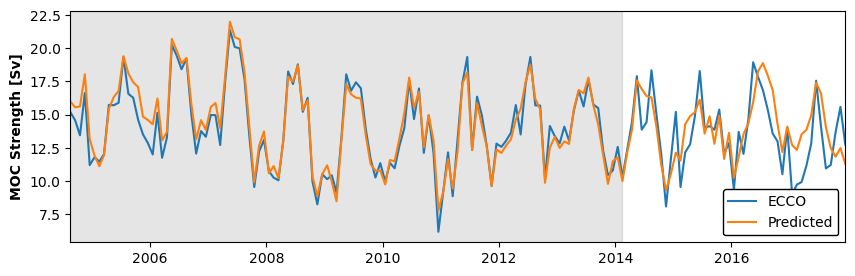

In [196]:
mean_arrays = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}
all_preds = mean_arrays['all_preds']
time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

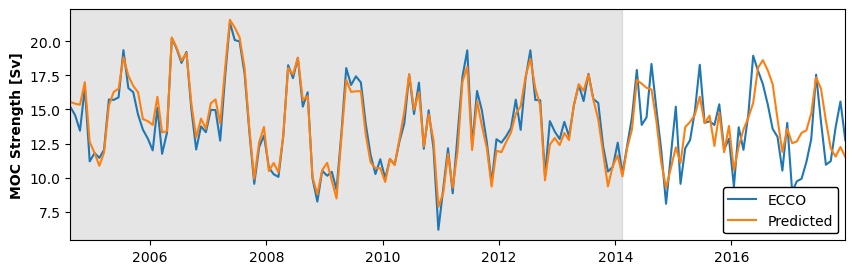

In [170]:
mean_arrays = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}
all_preds = mean_arrays['all_preds']
time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

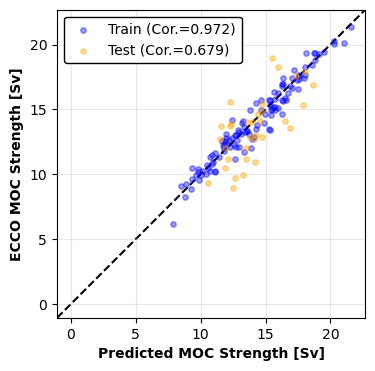

In [171]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(mean_arrays['train_set_pred']).squeeze()
y_pred_test = np.array(mean_arrays['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()